<div align="center">
<h1><a href="https://github.com/peremartra/Large-Language-Model-Notebooks-Course">LLM Hands On Course</a></h1>
    <h3>Understand And Apply Large Language Models</h3>
    <h2>Introduction to LoRA Tuning using PEFT from Hugging Face.</h2>
    <h3>Fine-tune a Foundational Model effortless</h3>
    <p>by <b>Pere Martra</b></p>
</div>

<br>

<div align="center">
    &nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/pere-martra/"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>
    
</div>

<br>
<hr>

# LoRA Tuning

In this notebook I'm introducing how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

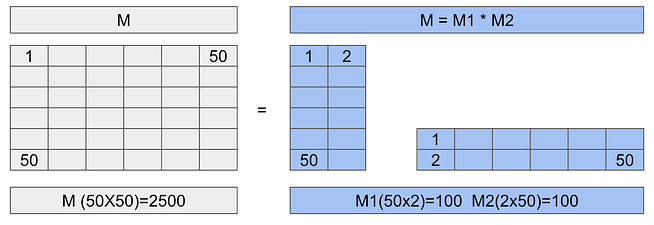

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (50x2) and (2x50), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
# !pip install -q peft==0.8.2
# !pip install -q datasets==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = 'Vikhrmodels/Vikhr-7B-instruct_0.4'
#model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="/app/model")
foundation_model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir="/app/model")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# Get the context size (maximum sequence length)
model_config = foundation_model.config
context_size = model_config.max_position_embeddings # model_config.seq_length 
print(f"Context size (maximum sequence length): {context_size}")

# Get the vocabulary size
vocab_size = tokenizer.vocab_size
print(f"Vocabulary size: {vocab_size}")

# Print some specific tokens and their corresponding IDs
specific_tokens = ["hello", "world", "transformers", "bloomz"]
for token in specific_tokens:
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"Token: {token}, ID: {token_id}")

Context size (maximum sequence length): 32768
Vocabulary size: 79085
Token: hello, ID: 21558
Token: world, ID: 9471
Token: transformers, ID: 0
Token: bloomz, ID: 0


## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [3]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=False, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [4]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=10)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['I want you to act as a motivational coach. \nWhat should be your response? \n']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [5]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset, cache_dir="app/data/")
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

When tokenizing text for input into models such as those in the Hugging Face Transformers library, two key components produced are `input_ids` and `attention_mask`. These components are essential for the model to process the text correctly.

**input_ids**

    Definition: The input_ids are the numerical representations of the tokens in the text.
    
    Purpose: They provide the model with the actual data it needs to understand and generate language.
    
    Details:
    Each token  in the input text is mapped to a unique integer ID from the tokenizer's vocabulary.

    
    For example, the sentence "Hello, world!" might be tokenized into [101, 7592, 999, 102], where each number corresponds to a token's ID in the model's vocabulary.


**attention_mask**

    Definition: The attention_mask is a binary mask that indicates which tokens should be attended to by the model and which should be ignored (typically used to handle padding).

    Purpose: It helps the model differentiate between real tokens and padding tokens, ensuring that padded tokens do not affect the model's output.


    Details:
    It is a list of 0s and 1s where 1 indicates a token that should be attended to (a real token) and 0 indicates a token that should be ignored (a padding token).

    For instance, if the input text is padded to a fixed length, the attention_mask ensures the padding does not contribute to the model's understanding of the text. For the tokenized sentence [101, 7592, 999, 102, 0, 0], the attention mask might be [1, 1, 1, 1, 0, 0].
    




In [6]:
print(train_sample[:1])

{'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[315, 947, 368, 298, 960, 390, 264, 12893, 1554, 17598, 28723, 315, 622, 1212, 15380, 304, 368, 622, 10071, 395, 767, 272, 17598, 1023, 1347, 28723, 315, 947, 368, 298, 865, 10071, 395, 272, 17598, 3825, 3416, 624, 4842, 2696, 2724, 28725, 304, 2511, 1112, 28723, 511, 459, 3324, 10928, 697, 28723, 511, 459, 1212, 15380, 6417, 315, 12317, 368, 298, 511, 579, 28723, 739, 613, 927, 298, 1912, 368, 1545, 297, 24670, 789, 28725, 613, 622, 511, 579, 486, 8190, 2245, 3416, 1191, 346, 1170, 468, 1468, 371, 4091, 456, 2051, 586, 907, 3445, 349, 2

# Fine-Tuning.
First is necesary create a LoRA config.


In [7]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(
    r=8, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules="all-linear", #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [8]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 20,971,520 || all params: 7,648,538,624 || trainable%: 0.2742
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [9]:
#Create a directory to contain the Model
import os
working_dir = '/app/model/lora'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [12]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=False,
    report_to=[]
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [ ]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

In [ ]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [ ]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a motivational coach.  I will provide some information about yourself and your goals, including the benefits of being fitter physically or mentally. You should also include any other factors that can help motivate people like myself in order for them not only improve their fitness but overall wellness']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

